# Part 1 of Lab1
**Contact:** *sheng.wang(at)anu.edu.au*

This is an example of [Part 1 of Lab1](https://github.com/sheng09/PHYS3070-2020/blob/master/Week2/Lab1.md#part-i-20-points) in Python.

In Part 1 of Lab1, we manually pick P and S arrivals, $t_P$ and $t_S$, for 8 stations. Based on the time difference $t_S-t_P$, we use `spdiff` to compute/measure the distance $\Delta$ and the P wave traveltime $T_p$. 

Then, with the a set of $\Delta$ measurements at many stations, we can locate the Earthquake. We use `equake` or `equakez` for the location. In `equake` or `equakez`, for each station we plot a circle and we set the radius to the measured $\Delta$. Therefore we have many circles, and the intersection point of those circles is the Earthquake location. However, there are errors in the measurement and computations so that the intersection cannot be perfect. 

`spdiff` is in *FORTRAN*, and `equake`/`equakez` is in bash, and a software `GMT` is used in plotting. Now, let us implement `spdiff` and `equake`/`equakez` in *Python*. 

Besides, here showcase how to locate the earthquake.


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from obspy import read as obspy_read
from mpl_toolkits.basemap import Basemap

Text(0, 0.5, 'Travel time difference (s)')

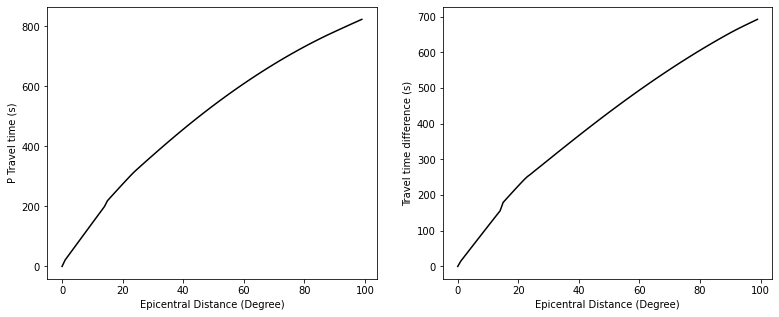

In [154]:
tmp = np.loadtxt('sptimes.tim', skiprows = 1)
distance = np.arange(tmp.shape[0] )
tP = tmp[:,0] # traveltime of P
tSP = tmp[:,1]# traveltime difference between P and S

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(distance, tP, label='P travel time', color='k')
ax1.set_xlabel('Epicentral Distance (Degree)')
ax1.set_ylabel('P Travel time (s)')

ax2.plot(distance, tSP, label='S-P time difference', color='k')
ax2.set_xlabel('Epicentral Distance (Degree)')
ax2.set_ylabel('Travel time difference (s)')

Obviously, given an traveltime difference measurement, we can determine the epicentral distance from the right plot above. Then, we can also obtain the P wave traveltime from the left plot above. That is what `spdiff` about. Now, let us implement it in *Python*.

In [81]:
def spdiff(time_difference):
    """
    This function takes a `time_difference`(s) and return the `epi_distance` (deg) and `P_traveltime`(s).
    """
    # First, we load `sptimes`
    tmp = np.loadtxt('sptimes.tim', skiprows = 1)
    distance = np.arange(tmp.shape[0] )
    tP = tmp[:,0] # traveltime of P
    tSP = tmp[:,1]# traveltime difference between P and S
    
    # We check if `time_difference` is valid
    if time_difference < tSP[0] or time_difference > tSP[-1]:
        print('Err, given time_difference (%f) is out of the search range.' % time_difference )
        sys.exit(-1)
    
    # Now we search for the interval
    idx0, idx1 = 0, 1
    n = tSP.size
    for idx in range(n-1):
        if tSP[idx] <= time_difference < tSP[idx+1]:
            # we found the interval
            idx0 = idx
            idx1 = idx + 1
            break
            
    # Now we conduct linear interpolation within that small interval
    d0, d1 = distance[idx0], distance[idx1]
    tsp0, tsp1 = tSP[idx0], tSP[idx1]
    
    k = (d1-d0)/(tsp1-tsp0)
    b = d0-k*tsp0
    d = k*time_difference+b
    
    tp0, tp1 = tP[idx0], tP[idx1]
    k = (tp1-tp0)/(tsp1-tsp0)
    b = tp0-k*tsp0
    p = k*time_difference+b
    return d, p

Now, we can play `spdiff(...)` here. We will use the measured time difference from all seismograms in  `EQ3/` to compute the epicentral distance.

In [143]:
# Test spdiff to check if it is correct
print( spdiff(203) )
print( spdiff(603.4) )
# For receiver CTAO, we have measured its tp-ts time difference in SAC
time_difference_ctao = 333.22
ctao_dist, ctao_traveltime_P = spdiff(time_difference_ctao)

(17.514477162518229, 247.08945649005366)
(79.531529815941028, 729.51675814729128)


In [144]:
def circle(lon1, lat1, radius_degree):
    """
    This function take a station coordinate (`lon1`, `lat1`) and the 
    epicentral distance (`radius`), and return a list of points for
    circle.
    """
    npt = 120
    
    
    rlat = np.deg2rad(lat1)
    rlon = np.deg2rad(lon1)
    rdel = np.deg2rad(radius_degree)
    sla = np.sin(rlat)
    cla = np.cos(rlat)
    sde = np.sin(rdel)
    cde = np.cos(rdel)
    pre = 360./(npt-1)
    blat = []
    blon = []
    for ips in range(npt):
        ps = np.deg2rad(pre*float(ips-1) )
        cps = np.cos(ps)
        sps = np.sin(ps)
        t0 = cla*cde + sla*sps*sde
        t3 = sla*cde - cla*sps*sde
        t1 = cps*sde 
        t2 = t0
        blat.append( np.rad2deg(np.arcsin(t3) ) )
        blon.append( np.rad2deg(np.arctan2(t1,t2) )+lon1)
    return blon, blat

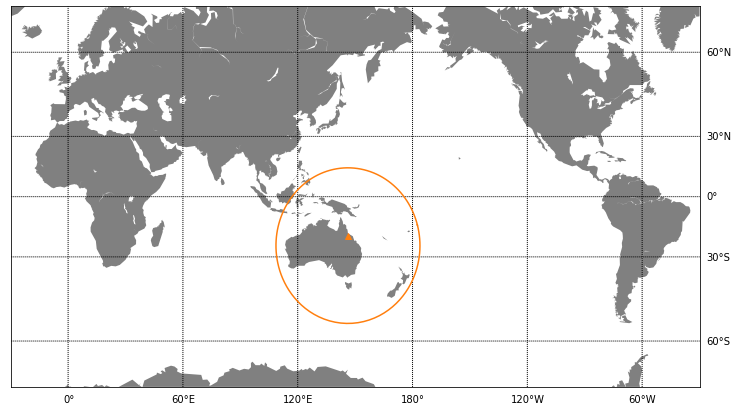

In [155]:
# Load station coordinates
tmp = np.loadtxt('stations.txt', dtype={'names': ('stnm', 'stlo', 'stla'), 'formats':('S8', np.float, np.float) })
station_dict = dict()
for it in tmp:
    station_dict[it['stnm'].decode('utf8') ] = (it['stlo'], it['stla'])
    
# Plot the basemap
fig, ax1 = plt.subplots(1, 1, figsize=(16, 7) )
m = Basemap(projection='merc',llcrnrlat=-70,urcrnrlat=70,\
            llcrnrlon=-30,urcrnrlon=330,lat_ts=20,resolution='c', ax=ax1)
m.fillcontinents(color='gray')
m.drawparallels(np.arange(-90.,91.,30.), labels=[False,True,True,False])
m.drawmeridians(np.arange(-180.,181.,60.), labels=[True,False,False,True])


# We can plot the circle for station CTAO
stanm = 'CTAO'
clr = 'C1'
stlo, stla = station_dict[stanm]
# the station
x, y = m(stlo, stla)
m.plot(x, y, marker='^', color= clr) 
# the circle
lons, lats = circle(stlo, stla, ctao_dist)
x, y = m(lons, lats)
m.plot(x, y, color= clr)

# You can compute and plot for other stations

The same, you can compute the epicentral distance for other stations, and then plot similar circles as above. Once you have plotted for all stations, you will find the intersection point of all the circles. That point will be the earthquake location.

**The similar, you can complete Part II and Part III, especially the programming in Part III.**